In [1]:
# Importing datasets
import pandas as pd
import numpy as np


In [49]:
train = pd.read_csv('train.csv', parse_dates=[1])
test = pd.read_csv('test.csv', parse_dates=[1])
df = train.copy()
df_test = test.copy()

In [54]:
df_test

,ID,Datetime
0,18288,2014-09-26 00:00:00
1,18289,2014-09-26 01:00:00
2,18290,2014-09-26 02:00:00
3,18291,2014-09-26 03:00:00
4,18292,2014-09-26 04:00:00
...,...,...
5107,23395,2015-04-26 19:00:00
5108,23396,2015-04-26 20:00:00
5109,23397,2015-04-26 21:00:00
5110,23398,2015-04-26 22:00:00


In [3]:
df.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


In [4]:
df_test.shape

(5112, 2)

In [5]:
df.drop('ID',inplace=True,axis =1)

In [6]:
df.head()

,Datetime,Count
0,2012-08-25 00:00:00,8
1,2012-08-25 01:00:00,2
2,2012-08-25 02:00:00,6
3,2012-08-25 03:00:00,2
4,2012-08-25 04:00:00,2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  18288 non-null  datetime64[ns]
 1   Count     18288 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 285.9 KB


### persistence model

In [62]:
df['c'] = df['Count'].shift(1)

In [63]:
df.shape[0]

18288

In [64]:
train, test = df[1:int(df.shape[0]*0.8)], df[int(df.shape[0]*0.8):]

In [65]:
train.shape,test.shape

((14629, 4), (3658, 4))

In [66]:
train.head()

,ID,Datetime,Count,c
1,1,2012-08-25 01:00:00,2,8.0
2,2,2012-08-25 02:00:00,6,2.0
3,3,2012-08-25 03:00:00,2,6.0
4,4,2012-08-25 04:00:00,2,2.0
5,5,2012-08-25 05:00:00,2,2.0


In [67]:
train_X, train_y = train['c'], train['Count']
test_X, test_y = test['c'], test['Count']

#### walk forward validation 

In [68]:
predictions = test_X.copy()

In [69]:
print(predictions)
print(test_y)

14630    206.0
14631    204.0
14632    172.0
14633    184.0
14634    124.0
         ...  
18283    680.0
18284    868.0
18285    732.0
18286    702.0
18287    580.0
Name: c, Length: 3658, dtype: float64
14630    204
14631    172
14632    184
14633    124
14634    190
        ... 
18283    868
18284    732
18285    702
18286    580
18287    534
Name: Count, Length: 3658, dtype: int64


In [70]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y[0:2], predictions[0:2])
mse
#mse of first 100 data
# mse of this model would be a criterion for other models.. if mse of a model be more than this mse, the modeel wouldnt be efficent. 

514.0

In [71]:
from matplotlib import pyplot as plt

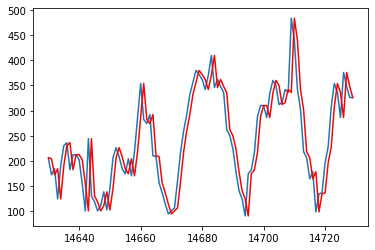

In [72]:
plt.plot(test_y[0:100])
plt.plot(predictions[0:100],color='red')

## auto regression model

In [116]:
train, test = df.Count[1:int(df.shape[0]*0.8)], df.Count[int(df.shape[0]*0.8):]

In [117]:
train.head()

1    2
2    6
3    2
4    2
5    2
Name: Count, dtype: int64

In [118]:
from statsmodels.tsa.ar_model import AR

In [119]:
model = AR(train)
model_fit = model.fit()

In [120]:
#number of lag values 
model_fit.k_ar

42

In [121]:
#Coef of lag variables
model_fit.params

const        1.443635
L1.Count     0.714994
L2.Count     0.140894
L3.Count     0.015470
L4.Count     0.038366
L5.Count     0.022670
L6.Count    -0.050786
L7.Count    -0.016974
L8.Count     0.015791
L9.Count    -0.027516
L10.Count   -0.004302
L11.Count    0.052985
L12.Count    0.021718
L13.Count   -0.012776
L14.Count   -0.011611
L15.Count   -0.003702
L16.Count   -0.018504
L17.Count   -0.022221
L18.Count   -0.003718
L19.Count    0.042346
L20.Count    0.000981
L21.Count    0.046979
L22.Count    0.049858
L23.Count    0.060790
L24.Count    0.103202
L25.Count   -0.029622
L26.Count   -0.057985
L27.Count   -0.042304
L28.Count   -0.024070
L29.Count   -0.015950
L30.Count   -0.027984
L31.Count   -0.007480
L32.Count    0.013335
L33.Count    0.001505
L34.Count   -0.004249
L35.Count    0.007998
L36.Count    0.022434
L37.Count   -0.000993
L38.Count   -0.042829
L39.Count   -0.004825
L40.Count    0.002422
L41.Count   -0.001032
L42.Count    0.040534
dtype: float64

In [122]:
predictions_ar = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

In [123]:
predictions_ar

14630    219.569404
14631    219.890327
14632    222.337004
14633    231.288321
14634    230.962741
            ...    
18283     89.326142
18284     89.326142
18285     89.326142
18286     89.326142
18287     89.326142
Length: 3658, dtype: float64

In [124]:
predictions_ar.iloc[0:2],test.iloc[0:2]

(14630    219.569404
 14631    219.890327
 dtype: float64,
 14630    204
 14631    172
 Name: Count, dtype: int64)

In [125]:
mse = mean_squared_error(test, predictions_ar)
mse

95729.64793098494

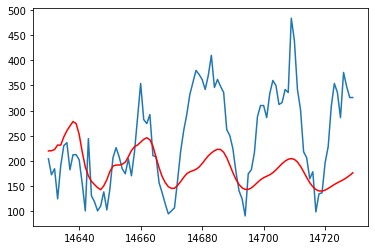

In [126]:
plt.plot(test_y[0:100])
plt.plot(predictions_ar[0:100], color='red')
#plot of first 100 data compare to real values

### walk forward 

In [131]:
data = train
predict =[]
count = 0
for t in test[0:100]:
    model = AR(data)
    model_fit = model.fit()
    y = model_fit.predict(start=len(data), end=len(train)+len(test[0:100])-1)
    print(y.values[0],count)
    count +=1
    predict.append(y.values[0])
    data = np.append(data, t)
    data = pd.Series(data)
    
#prediction of first 100 data in test with walk forward method

F:\Anaconda\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


219.5694039478371 0
208.7500119904072 1
185.87282909942854 2
196.86287437618296 3
147.51370199938702 4
200.21312628427742 5
238.3283282166324 6
246.67414323298564 7
210.47327395267743 8
218.33576863148377 9
200.80111941408626 10
168.09896615640224 11
130.99470813843604 12
96.62519250716102 13
194.68272588155378 14
137.47749484891992 15
119.15868624073623 16
111.63544618840616 17
124.86542722775286 18
142.69922830895106 19
129.77338763164286 20
156.98038459221303 21
187.67083418433828 22
208.16263145630796 23
203.03830894049855 24
187.54065398439556 25
181.5362984157996 26
200.26955465687553 27
185.84382539200232 28
214.16364172115397 29
262.96495882979394 30
316.3061108822137 31
287.58253694891715 32
272.6708968713926 33
281.0064186392609 34
201.03777170302723 35
182.01061307746173 36
161.1568776194425 37
122.53786604331336 38
96.5804443940069 39
95.4963837882649 40
114.04343468885945 41
120.38086807402915 42
153.0032287096751 43
213.3111867722295 44
259.544924236386 45
281.67415776928

In [132]:
predict[0],test.iloc[0]

(219.5694039478371, 204)

In [133]:
mse = mean_squared_error(test[0:100].values, predict)
mse

1606.1019957438618

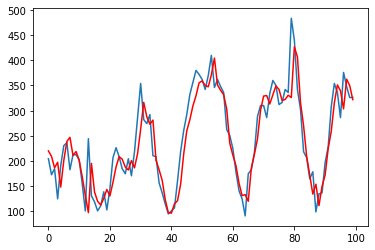

In [134]:
plt.plot(test[0:100].values)
plt.plot(predict, color ='red')


In [105]:
#preedicting df_test 

### moving average model 

In [135]:
df.head()

,ID,Datetime,Count,c,resid
0,0,2012-08-25 00:00:00,8,NaN,NaN
1,1,2012-08-25 01:00:00,2,8.0,-6.0
2,2,2012-08-25 02:00:00,6,2.0,4.0
3,3,2012-08-25 03:00:00,2,6.0,-4.0
4,4,2012-08-25 04:00:00,2,2.0,0.0


In [136]:
df['resid'] = df.Count - df.c

In [137]:
df.head()

,ID,Datetime,Count,c,resid
0,0,2012-08-25 00:00:00,8,NaN,NaN
1,1,2012-08-25 01:00:00,2,8.0,-6.0
2,2,2012-08-25 02:00:00,6,2.0,4.0
3,3,2012-08-25 03:00:00,2,6.0,-4.0
4,4,2012-08-25 04:00:00,2,2.0,0.0


In [138]:
train, test = df.resid[1:int(df.shape[0]*0.8)], df.Count[int(df.shape[0]*0.8):]

In [139]:
train.head()

1   -6.0
2    4.0
3   -4.0
4    0.0
5    0.0
Name: resid, dtype: float64

In [140]:
test.head()

14630    204
14631    172
14632    184
14633    124
14634    190
Name: Count, dtype: int64

In [141]:
model = AR(train)
model_fit = model.fit()

F:\Anaconda\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


In [142]:
model_fit.k_ar

42

In [143]:
model_fit.params

const        0.051986
L1.resid    -0.284713
L2.resid    -0.143025
L3.resid    -0.127246
L4.resid    -0.088258
L5.resid    -0.063212
L6.resid    -0.113799
L7.resid    -0.131666
L8.resid    -0.115936
L9.resid    -0.142904
L10.resid   -0.146821
L11.resid   -0.094152
L12.resid   -0.071745
L13.resid   -0.082929
L14.resid   -0.093575
L15.resid   -0.095932
L16.resid   -0.112117
L17.resid   -0.131398
L18.resid   -0.133629
L19.resid   -0.096455
L20.resid   -0.098336
L21.resid   -0.053668
L22.resid   -0.005876
L23.resid    0.055121
L24.resid    0.156283
L25.resid    0.126832
L26.resid    0.069945
L27.resid    0.028655
L28.resid    0.004964
L29.resid   -0.010220
L30.resid   -0.037346
L31.resid   -0.045594
L32.resid   -0.034610
L33.resid   -0.032466
L34.resid   -0.035061
L35.resid   -0.027469
L36.resid   -0.003858
L37.resid   -0.001962
L38.resid   -0.045796
L39.resid   -0.052232
L40.resid   -0.050263
L41.resid   -0.057840
L42.resid   -0.051949
dtype: float64

In [144]:
pred_resid = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

In [145]:
pred_resid

14630    15.690801
14631     5.560292
14632     3.709138
14633     8.067949
14634     6.211054
           ...    
18283     0.014972
18284     0.014972
18285     0.014972
18286     0.014972
18287     0.014972
Length: 3658, dtype: float64

In [146]:
predictions_resid = df.c[int(df.shape[0]*0.8):] + pred_resid

In [147]:
predictions_resid.iloc[2],test.iloc[2]

(175.70913845202233, 184)

In [148]:
mse = mean_squared_error(test[0:100], predictions_resid[0:100])
mse

1979.1738960228604

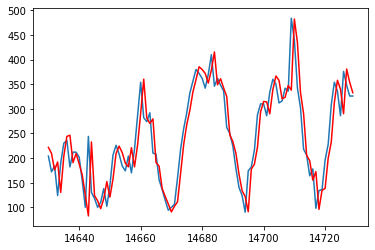

In [152]:
plt.plot(test[0:100])
plt.plot(predictions_resid[0:100], color='red')

# Arima model

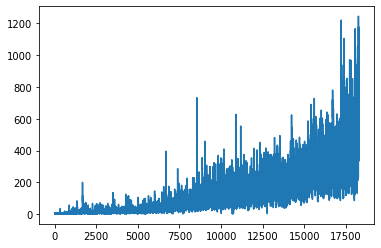

In [153]:
df.Count.plot()

#trend is exponential.
D=2

### Autocorrelation Plot

In [154]:
from pandas.plotting import autocorrelation_plot

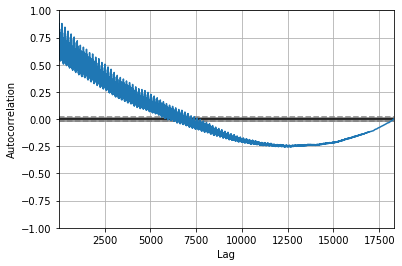

In [156]:
autocorrelation_plot(df['Count'])

q=5000

## Partial Autocorrelation Graph

In [157]:
from statsmodels.graphics.tsaplots import plot_pacf

In [158]:
df.Count

0          8
1          2
2          6
3          2
4          2
        ... 
18283    868
18284    732
18285    702
18286    580
18287    534
Name: Count, Length: 18288, dtype: int64

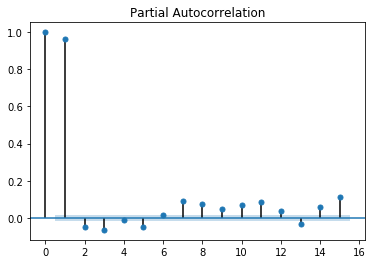

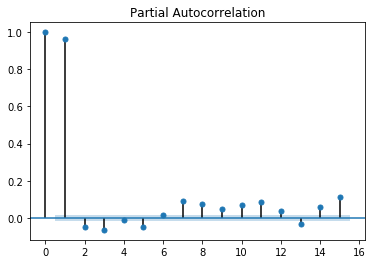

In [159]:
plot_pacf(df['Count'], lags=15)

p =1 

In [160]:
from statsmodels.tsa.arima_model import ARIMA

In [197]:
model = ARIMA(df['Count'][0:100], order=(4,2,0))

In [198]:
df.head()

,ID,Datetime,Count,c,resid
0,0,2012-08-25 00:00:00,8,NaN,NaN
1,1,2012-08-25 01:00:00,2,8.0,-6.0
2,2,2012-08-25 02:00:00,6,2.0,4.0
3,3,2012-08-25 03:00:00,2,6.0,-4.0
4,4,2012-08-25 04:00:00,2,2.0,0.0


In [199]:
df.tail()

,ID,Datetime,Count,c,resid
18283,18283,2014-09-25 19:00:00,868,680.0,188.0
18284,18284,2014-09-25 20:00:00,732,868.0,-136.0
18285,18285,2014-09-25 21:00:00,702,732.0,-30.0
18286,18286,2014-09-25 22:00:00,580,702.0,-122.0
18287,18287,2014-09-25 23:00:00,534,580.0,-46.0


In [201]:
model_fit = model.fit()

In [202]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Count   No. Observations:                   98
Model:                 ARIMA(4, 2, 0)   Log Likelihood                -205.826
Method:                       css-mle   S.D. of innovations              1.956
Date:                Wed, 25 Nov 2020   AIC                            423.653
Time:                        11:45:16   BIC                            439.163
Sample:                             2   HQIC                           429.926
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0091      0.046      0.196      0.844      -0.081       0.099
ar.L1.D2.Count    -1.2839      0.101    -12.669      0.000      -1.483      -1.085
ar.L2.D2.Count    -1.1936      0.153     -7.785      0.000      -1.494      -0.893
ar.L3.D2.Count    -0.6515      0.155     -4.213      0.000      -0.955      -0.348
ar.L4.D2.Count    -0.2237      0.105     -2.124      0.034      -0.430      -0.017
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2190           -1.3622j            1.3797           -0.2754
AR.2           -0.2190           +1.3622j            1.3797            0.2754
AR.3           -1.2374           -0.9040j            1.5324           -0.3996
AR.4           -1.2374           +0.9040j            1.5324            0.3996
-----------------------------------------------------------------------------
"""

In [204]:
residuals = model_fit.resid

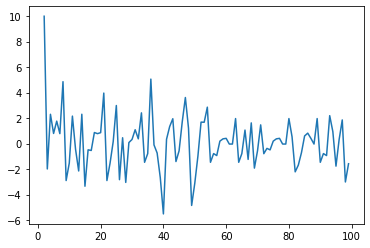

In [205]:
residuals.plot()
#should be like white noise

In [206]:
residuals.describe()

count    98.000000
mean      0.091798
std       2.139956
min      -5.522477
25%      -1.177770
50%       0.115437
75%       1.173519
max       9.990941
dtype: float64

In [207]:
output = model_fit.forecast()

In [208]:
output

(array([3.17064085]), array([1.95600592]), array([[-0.6630603,  7.004342 ]]))

In [175]:
model_fit.forecast(5)[0]

array([3.77358849, 2.88894213, 3.14172573, 3.93102089, 3.26388132])

In [176]:
df.Count

0          8
1          2
2          6
3          2
4          2
        ... 
18283    868
18284    732
18285    702
18286    580
18287    534
Name: Count, Length: 18288, dtype: int64

### Walk Forward Arima 

In [209]:
df.head()

,ID,Datetime,Count,c,resid
0,0,2012-08-25 00:00:00,8,NaN,NaN
1,1,2012-08-25 01:00:00,2,8.0,-6.0
2,2,2012-08-25 02:00:00,6,2.0,4.0
3,3,2012-08-25 03:00:00,2,6.0,-4.0
4,4,2012-08-25 04:00:00,2,2.0,0.0


In [214]:
train_size = int(df.shape[0]*0.7)
train, test = df.Count[0:train_size], df.Count[train_size:]

0

In [212]:
test.shape

(5487,)

In [221]:
data = train
predict =[]
count =1
for t in test[0:100]:
    model = ARIMA(data, order=(5,1,0))
    model_fit = model.fit()
    y = model_fit.forecast()
    print(y[0][0],count)
    predict.append(y[0][0])
    data = np.append(data, t)
    data = pd.Series(data)
    count+=1

172.88700451267135 1
207.08725764522313 2
199.13243483624507 3
182.40764731893574 4
187.23669279383384 5
182.84238274465793 6
179.8597387200494 7
179.91760755392446 8
167.7119514570858 9
128.99754991392328 10
165.55532697945105 11
187.5972622716105 12
205.52980713180605 13
222.7171190626371 14
275.904498981653 15
269.12144602262487 16
247.5464104546535 17
230.77103412075547 18
215.69783095384005 19
178.18885012685698 20
199.37726175568355 21
182.5256295252738 22
247.62114555046347 23
223.62524360585167 24
240.93972167595834 25
322.0214971268174 26
364.6594392032601 27
388.5117915777589 28
394.01441561537507 29
386.6360153583707 30
389.9282532013455 31
369.20972222966543 32
362.2386089204166 33
324.97757341651516 34
335.0309837422571 35
325.26577409243276 36
312.8094473672491 37
316.9559042506875 38
330.1808988909985 39
307.3465540519252 40
226.70942201269787 41
176.59371939349717 42
166.9498226474287 43
137.7523363575758 44
148.16841919820789 45
125.06873912384884 46
87.93464384143161 

In [223]:
predict 

[172.88700451267135,
 207.08725764522313,
 199.13243483624507,
 182.40764731893574,
 187.23669279383384,
 182.84238274465793,
 179.8597387200494,
 179.91760755392446,
 167.7119514570858,
 128.99754991392328,
 165.55532697945105,
 187.5972622716105,
 205.52980713180605,
 222.7171190626371,
 275.904498981653,
 269.12144602262487,
 247.5464104546535,
 230.77103412075547,
 215.69783095384005,
 178.18885012685698,
 199.37726175568355,
 182.5256295252738,
 247.62114555046347,
 223.62524360585167,
 240.93972167595834,
 322.0214971268174,
 364.6594392032601,
 388.5117915777589,
 394.01441561537507,
 386.6360153583707,
 389.9282532013455,
 369.20972222966543,
 362.2386089204166,
 324.97757341651516,
 335.0309837422571,
 325.26577409243276,
 312.8094473672491,
 316.9559042506875,
 330.1808988909985,
 307.3465540519252,
 226.70942201269787,
 176.59371939349717,
 166.9498226474287,
 137.7523363575758,
 148.16841919820789,
 125.06873912384884,
 87.93464384143161,
 113.14095405256492,
 122.902910257

In [224]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test[0:100].values, predict)
mse

1242.4543837775632

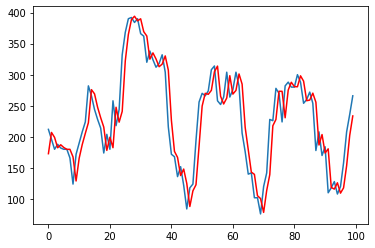

In [226]:
plt.plot(test[0:100].values)
plt.plot(predict, color ='red')